# MB_EP_PILO

In [188]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [189]:
import seaborn as sns
sns.set()

In [190]:
df = pd.read_excel("/Users/michaelzhang/Desktop/multiclass/pilo_ep_mb_features.xlsx")

In [191]:
reduced_features = pd.read_excel("/Users/michaelzhang/Desktop/multiclass/LASSO_reduced_features.xlsx")

In [192]:
reduced_features_list = reduced_features.loc[reduced_features['MB/EP/Pilo'].isnull() == False, ['MB/EP/Pilo']].values.tolist()

In [193]:
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [194]:
target = df["path"]

In [195]:
target.value_counts()

mb      278
pilo    160
ep       97
Name: path, dtype: int64

In [196]:
#Marking 0 as ep and 1 as pilo and 2 as mb
mapping_dict = {0: 'ep', 1: 'pilo', 2: 'mb'}
target = target.map(dict(ep = 0, pilo = 1, mb = 2))

In [197]:
features_after_lasso = df[reduced_features_list]

In [198]:
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)

In [199]:
y_train.value_counts()

2    218
1    115
0     68
Name: path, dtype: int64

In [200]:
y_test.value_counts()

2    60
1    45
0    29
Name: path, dtype: int64

# Principal Components Analysis - [Removed]

# Resampling to correct for imbalance

In [201]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['path'] == 0]
X_1 = X[X['path'] == 1]
X_2 = X[X['path'] == 2]

In [202]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_2), random_state = 42)
upsampled_1 = resample(X_1, replace = True, n_samples = len(X_2), random_state = 42)
upsampled = pd.concat([upsampled_0, upsampled_1, X_2])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [203]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

In [204]:
y_train.value_counts()

2    218
1    218
0    218
Name: path, dtype: int64

In [205]:
y_train_bin = label_binarize(y_train, classes = [0, 1, 2])
y_test_bin = label_binarize(y_test, classes = [0, 1, 2])

# Standardizing Features

In [206]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [207]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [208]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

In [209]:
def specificity_score(y_pred, y_true):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [210]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [211]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [212]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.4f} - {:0.4}]".format(name, i,
        confidence_lower, confidence_upper))

In [213]:
def my_classification_report(y_test_np, y_pred):

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    spec_arr = []
    ppv_arr = [] ##
    npv_arr = [] ##
    rec_arr = []
    acc_arr = [] 

    print("Specificities")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TN += TN
        tot_FP += FP
        spec_arr.append(TN/(TN+FP))
        print(group, spec_arr[group])

    print("Macro Avg : " + str(np.array(spec_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("PPV/Precision") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TP += TP
        tot_FP += FP
        ppv_arr.append(TP/(TP+FP))
        print(group, ppv_arr[group])
    
    print("Macro Avg : " + str(np.array(ppv_arr).mean()))
    prec_for_mic_f1 = tot_TP / (tot_TP + tot_FP)
    print("Micro Avg : " + str(prec_for_mic_f1), '\n')

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("NPV") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TN += TN
        tot_FN += FN
        npv_arr.append(TN/(TN+FN))
        print(group, npv_arr[group])
    
    print("Macro Avg : " + str(np.array(npv_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN)), '\n') 
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Recall") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TP += TP
        tot_FN += FN
        rec_arr.append(TP/(TP+FN))
        print(group, rec_arr[group])
    
    print("Macro Avg : " + str(np.array(rec_arr).mean()))
    rec_for_mic_f1 = tot_TP / (tot_TP + tot_FN)
    print("Micro Avg : " + str(rec_for_mic_f1), '\n')
    
    print("F1 Score") ##
    for group in range(3):
        print(group, 2 * (rec_arr[group] * ppv_arr[group]) / (rec_arr[group] + ppv_arr[group]))
    print("Macro Avg : " + str(2 * (np.array(rec_arr).mean() * np.array(ppv_arr).mean()) 
                               / (np.array(rec_arr).mean() + np.array(ppv_arr).mean())))
    print("Micro Avg : " + str(2 * (prec_for_mic_f1 * rec_for_mic_f1)/ (prec_for_mic_f1 + rec_for_mic_f1)), '\n')
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Accuracy:")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        
        tot_TP += TP
        tot_TN += TN
        tot_FP += FP
        tot_FN += FN
        
        acc_arr.append((TP + TN)/(TP + TN + FP + FN))
        print(group, acc_arr[group])
        #print("TP:" + str(TP))
        #print("TN:" + str(TN))
        #print("FP:" + str(FP))
        #print("FN:" + str(FN))
        
        #print(TP + TN)
        #print(TP + TN + FP + FN, '\n')
        
    #print("Total TP:" + str(tot_TP))
    #print("Total TN:" + str(tot_TN))
    #print("Total FP:" + str(tot_FP))
    #print("Total FN:" + str(tot_FN), '\n')

    print("Macro Avg : " + str(np.array(acc_arr).mean()))
    print("Micro Avg : " + str((tot_TP + tot_TN)/(tot_TP + tot_TN + tot_FP + tot_FN)), '\n') ##

# SVM

### Grid Search for Hyperparameters

In [214]:
svm_model = OneVsRestClassifier(svm.SVC())

In [215]:
grid_param = {'estimator__C': [0.1, 1, 10],
              'estimator__gamma': [1, 0.1, 0.01]
}


svm_grid = GridSearchCV(estimator=svm_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [216]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=SVC()), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__gamma': [1, 0.1, 0.01]},
             scoring='accuracy')

In [217]:
print(svm_grid.best_params_)

{'estimator__C': 10, 'estimator__gamma': 0.1}


### Model Performance

In [218]:
svm_model = OneVsRestClassifier(svm.SVC(C = 10, gamma = 0.1, probability = True))
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [219]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.9809523809523809
1 1.0
2 0.21621621621621623
Macro Avg : 0.7323895323895324
Micro Avg : 0.7761194029850746 

PPV/Precision
0 0.6
1 1.0
2 0.5
Macro Avg : 0.7000000000000001
Micro Avg : 0.5522388059701493 

NPV
0 0.7984496124031008
1 0.7355371900826446
2 0.8888888888888888
Macro Avg : 0.8076252304582114
Micro Avg : 0.7761194029850746 

Recall
0 0.10344827586206896
1 0.28888888888888886
2 0.9666666666666667
Macro Avg : 0.4530012771392082
Micro Avg : 0.5522388059701493 

F1 Score
0 0.17647058823529413
1 0.4482758620689655
2 0.6590909090909091
Macro Avg : 0.5500443066016837
Micro Avg : 0.5522388059701493 

Accuracy:
0 0.7910447761194029
1 0.7611940298507462
2 0.5522388059701493
Macro Avg : 0.7014925373134329
Micro Avg : 0.7014925373134329 



In [220]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.10      0.18        29
           1       1.00      0.29      0.45        45
           2       0.50      0.97      0.66        60

    accuracy                           0.55       134
   macro avg       0.70      0.45      0.43       134
weighted avg       0.69      0.55      0.48       134



In [221]:
n_classes = 3
svm_model_for_auc = OneVsRestClassifier(svm.SVC(C = 10, gamma = 0.1, probability = True))
y_score = svm_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = svm_model_for_auc.predict(X_test)

ep
Accuracy: 0.8059701492537313
ROC: 0.8479474548440066 

pilo
Accuracy: 0.7313432835820896
ROC: 0.9540574282147316 

mb
Accuracy: 0.6194029850746269
ROC: 0.8351351351351352 

Micro-Averaged AUC: 0.8088104254845176


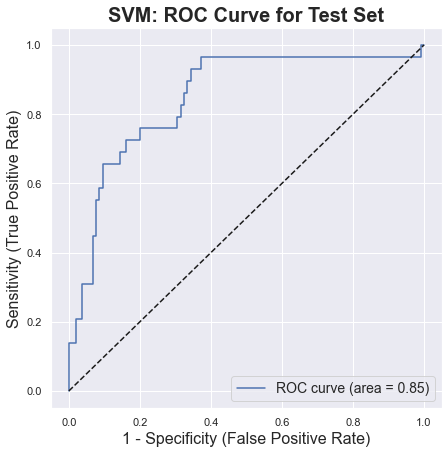

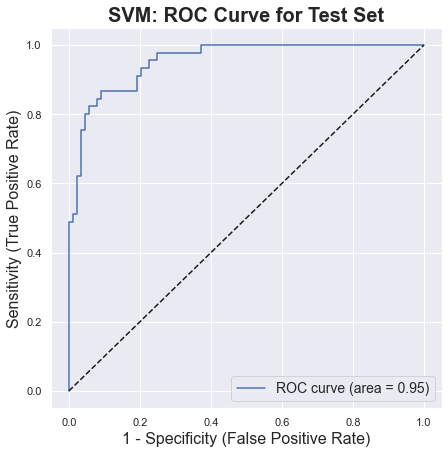

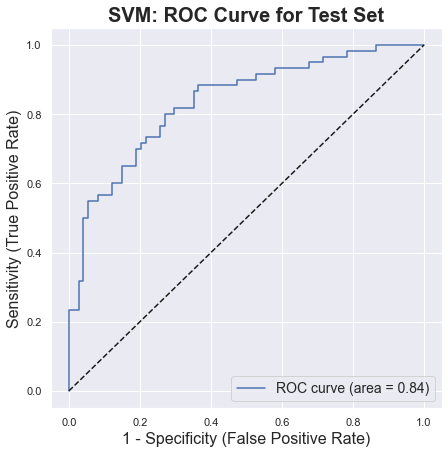

In [222]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print("ROC: " + str(roc_auc[i]), '\n')
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))



# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('SVM: ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()


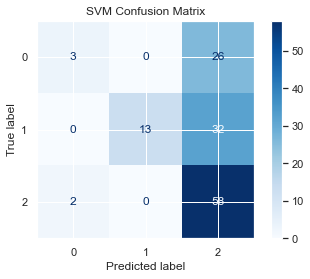

In [223]:
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show(matrix)
plt.show()

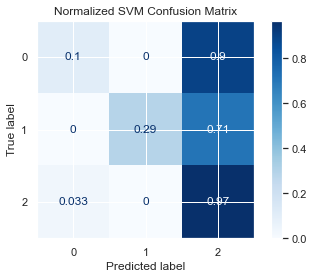

In [224]:
norm_matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized SVM Confusion Matrix')
plt.show(matrix)
plt.show()

In [225]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##

    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [226]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.7581 - 0.9209]
95% Confidence interval for the AUC score for class 1: [0.9184 - 0.9809]
95% Confidence interval for the AUC score for class 2: [0.7634 - 0.8977]
95% Confidence interval for the Accuracy score for class 0: [0.7388 - 0.8731]
95% Confidence interval for the Accuracy score for class 1: [0.6567 - 0.806]
95% Confidence interval for the Accuracy score for class 2: [0.5373 - 0.7015]
95% Confidence interval for the Specificity score for class 0: [1.0000 - 1.0]
95% Confidence interval for the Specificity score for class 1: [1.0000 - 1.0]
95% Confidence interval for the Specificity score for class 2: [0.2466 - 0.4769]
95% Confidence interval for the Precision score for class 0: [0.0000 - 0.2273]
95% Confidence interval for the Precision score for class 1: [0.0857 - 0.3256]
95% Confidence interval for the Precision score for class 2: [0.8654 - 0.9846]
95% Confidence interval for the Recall score for class 0: [0.0000 - 1.0]
9

# Logistic Regression

### Grid Search for Hyperparameters

In [227]:
lr_model = OneVsRestClassifier(LogisticRegression(max_iter = 2000))
grid_param = {'estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'estimator__C': [10, 1, 0.1, 0.01, 0.001]
}

lr_grid = GridSearchCV(estimator=lr_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [228]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000)),
             n_jobs=-1,
             param_grid={'estimator__C': [10, 1, 0.1, 0.01, 0.001],
                         'estimator__penalty': ['l1', 'l2', 'elasticnet',
                                                'none']},
             scoring='accuracy')

In [229]:
print(lr_grid.best_params_)

{'estimator__C': 10, 'estimator__penalty': 'l2'}


### Model Performance

In [230]:
lr_model = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 10, max_iter = 2000))
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [231]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.819047619047619
1 0.9775280898876404
2 0.8108108108108109
Macro Avg : 0.8691288399153567
Micro Avg : 0.8694029850746269 

PPV/Precision
0 0.4411764705882353
1 0.9487179487179487
2 0.7704918032786885
Macro Avg : 0.720128740861624
Micro Avg : 0.7388059701492538 

NPV
0 0.86
1 0.9157894736842105
2 0.821917808219178
Macro Avg : 0.8659024273011294
Micro Avg : 0.8694029850746269 

Recall
0 0.5172413793103449
1 0.8222222222222222
2 0.7833333333333333
Macro Avg : 0.7075989782886335
Micro Avg : 0.7388059701492538 

F1 Score
0 0.47619047619047616
1 0.8809523809523809
2 0.7768595041322314
Macro Avg : 0.7138088788711647
Micro Avg : 0.7388059701492538 

Accuracy:
0 0.753731343283582
1 0.9253731343283582
2 0.7985074626865671
Macro Avg : 0.8258706467661692
Micro Avg : 0.8258706467661692 



In [232]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.52      0.48        29
           1       0.95      0.82      0.88        45
           2       0.77      0.78      0.78        60

    accuracy                           0.74       134
   macro avg       0.72      0.71      0.71       134
weighted avg       0.76      0.74      0.75       134



In [233]:
n_classes = 3
lr_model_for_auc = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 10, max_iter = 2000, random_state = 42))
y_score = lr_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = lr_model_for_auc.predict(X_test)

ep
Accuracy: 0.7313432835820896
ROC: 0.7671592775041051 

pilo
Accuracy: 0.9477611940298507
ROC: 0.9890137328339574 

mb
Accuracy: 0.7761194029850746
ROC: 0.890990990990991 

Micro-Averaged AUC: 0.9013978614390733


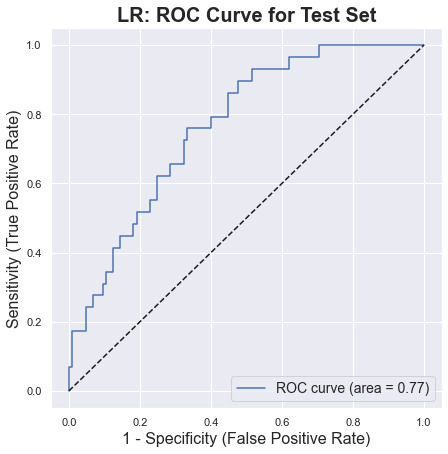

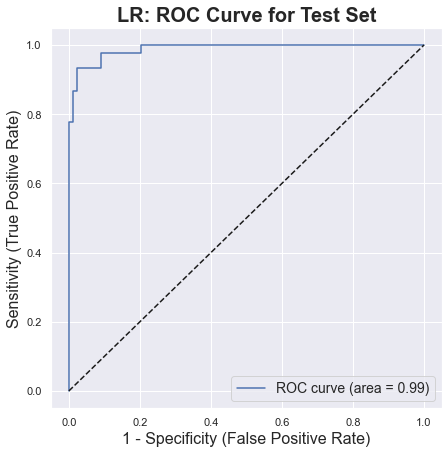

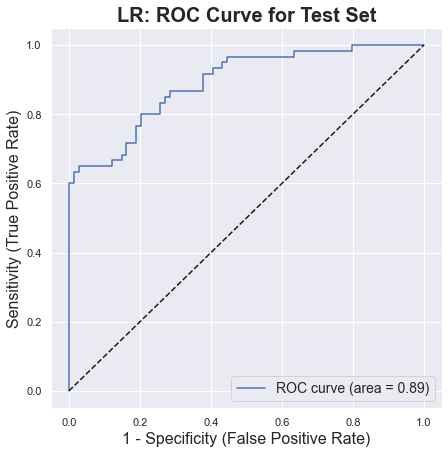

In [234]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print("ROC: " + str(roc_auc[i]), '\n')
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('LR: ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

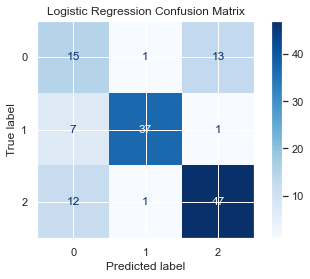

In [235]:
matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

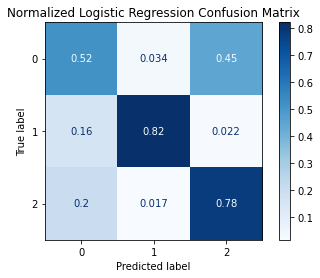

In [236]:
sns.reset_orig()
norm_matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Logistic Regression Confusion Matrix')
plt.show(norm_matrix)
plt.show()

sns.set()

In [237]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [238]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.6721 - 0.8519]
95% Confidence interval for the AUC score for class 1: [0.9742 - 0.9986]
95% Confidence interval for the AUC score for class 2: [0.8336 - 0.9401]
95% Confidence interval for the Accuracy score for class 0: [0.6567 - 0.806]
95% Confidence interval for the Accuracy score for class 1: [0.9104 - 0.9776]
95% Confidence interval for the Accuracy score for class 2: [0.7015 - 0.8433]
95% Confidence interval for the Specificity score for class 0: [0.7059 - 0.866]
95% Confidence interval for the Specificity score for class 1: [0.9639 - 1.0]
95% Confidence interval for the Specificity score for class 2: [0.7656 - 0.9265]
95% Confidence interval for the Precision score for class 0: [0.3333 - 0.7]
95% Confidence interval for the Precision score for class 1: [0.7609 - 0.9556]
95% Confidence interval for the Precision score for class 2: [0.5645 - 0.8]
95% Confidence interval for the Recall score for class 0: [0.2432 - 0.575]
95%

Feature: 0, Score: -1.02518
Feature: 1, Score: 0.25611
Feature: 2, Score: -0.68982
Feature: 3, Score: 0.49227
Feature: 4, Score: -1.94952
Feature: 5, Score: 1.56056
Feature: 6, Score: 0.31742
Feature: 7, Score: -0.30942
Feature: 8, Score: -1.27042
Feature: 9, Score: 0.66537
Feature: 10, Score: 1.32832
Feature: 11, Score: 0.26220
Feature: 12, Score: 0.57967
Feature: 13, Score: 0.48888
Feature: 14, Score: 0.25606
Feature: 15, Score: -0.54353
Feature: 16, Score: -1.45989
Feature: 17, Score: 0.29528
Feature: 18, Score: -0.44000
Feature: 19, Score: 0.87280
Feature: 20, Score: -0.67299
Feature: 21, Score: 0.63037
Feature: 22, Score: 2.34440
Feature: 23, Score: -0.88532
Feature: 24, Score: 0.34830
Feature: 25, Score: 0.06230
Feature: 26, Score: 0.57523
Feature: 27, Score: -1.13472
Feature: 28, Score: 0.06127
Feature: 29, Score: 0.00953
Feature: 30, Score: -0.17052
Feature: 31, Score: -0.33807
Feature: 32, Score: 1.52589
Feature: 33, Score: -0.03406
Feature: 34, Score: -0.18891
Feature: 35, Sc

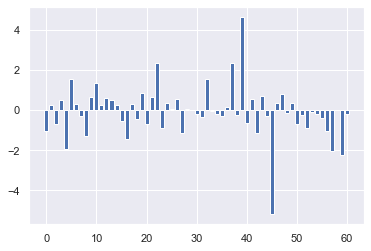

In [239]:
importance = lr_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

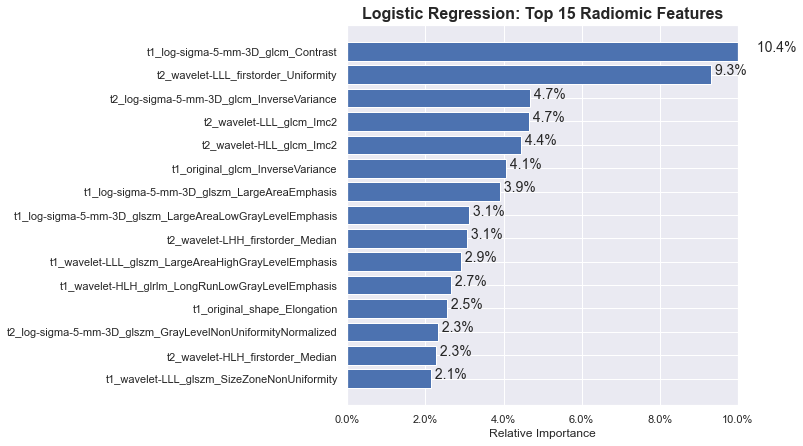

In [240]:
feature_names = X_test.columns.to_list()
importance = lr_model.coef_[0]
importance = np.abs(importance) / np.sum(np.abs(importance))
indices = np.argsort(importance)

plt.figure(figsize=(7, 7)) ##
plt.title('Logistic Regression: Top 15 Radiomic Features', fontsize=16, fontweight='semibold')
plt.barh(range(len(indices[-15:])), importance[indices[-15:]], color='b', align='center')
plt.xlim(0, 0.10) ##
for index, value in enumerate(importance[indices[-15:]]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices[-15:])), [feature_names[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

# KNN

### Grid Search for Hyperparameters

In [241]:
knn_model = KNeighborsClassifier()
grid_param = {'n_neighbors': [3, 5, 7]
}

knn_grid = GridSearchCV(estimator=knn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [242]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7]}, scoring='accuracy')

In [243]:
print(knn_grid.best_params_)

{'n_neighbors': 3}


### Model Performance

In [244]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [245]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.8095238095238095
1 0.9438202247191011
2 0.7702702702702703
Macro Avg : 0.8412047681710603
Micro Avg : 0.8432835820895522 

PPV/Precision
0 0.47368421052631576
1 0.8648648648648649
2 0.711864406779661
Macro Avg : 0.6834711607236139
Micro Avg : 0.6865671641791045 

NPV
0 0.8854166666666666
1 0.865979381443299
2 0.76
Macro Avg : 0.8371320160366551
Micro Avg : 0.8432835820895522 

Recall
0 0.6206896551724138
1 0.7111111111111111
2 0.7
Macro Avg : 0.6772669220945083
Micro Avg : 0.6865671641791045 

F1 Score
0 0.5373134328358208
1 0.7804878048780488
2 0.7058823529411764
Macro Avg : 0.6803548974024177
Micro Avg : 0.6865671641791045 

Accuracy:
0 0.7686567164179104
1 0.8656716417910447
2 0.7388059701492538
Macro Avg : 0.7910447761194029
Micro Avg : 0.7910447761194029 



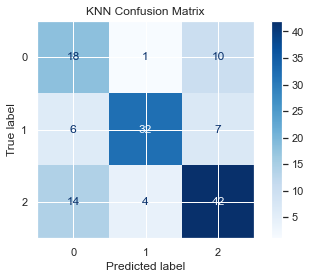

In [246]:
matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show(matrix)
plt.show()

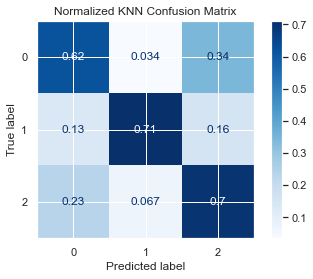

In [247]:
norm_matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized KNN Confusion Matrix')
plt.show(matrix)
plt.show()

ep
Accuracy: 0.7686567164179104
ROC: 0.7666666666666667 

pilo
Accuracy: 0.8656716417910447
ROC: 0.8870162297128589 

mb
Accuracy: 0.7388059701492538
ROC: 0.7743243243243243 

Micro-Averaged AUC: 0.8162731120516818


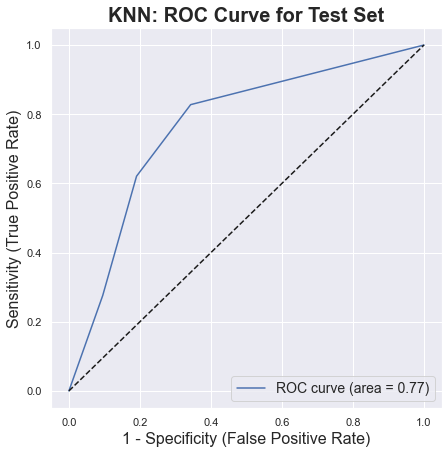

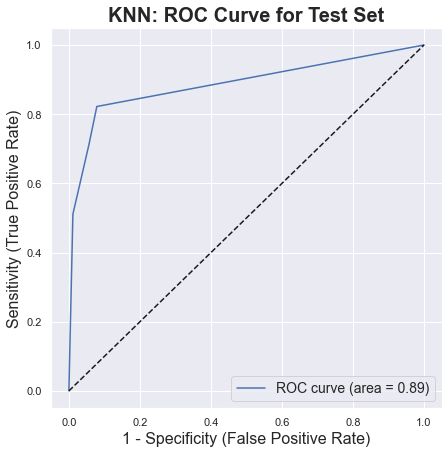

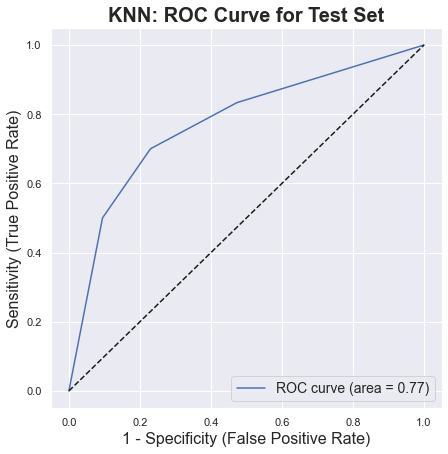

In [248]:
y_score = knn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print("ROC: " + str(roc_auc[i]), '\n')
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('KNN: ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [249]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [250]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.6733 - 0.8565]
95% Confidence interval for the AUC score for class 1: [0.8218 - 0.9436]
95% Confidence interval for the AUC score for class 2: [0.6922 - 0.8488]
95% Confidence interval for the Accuracy score for class 0: [0.7015 - 0.8433]
95% Confidence interval for the Accuracy score for class 1: [0.8060 - 0.9179]
95% Confidence interval for the Accuracy score for class 2: [0.6567 - 0.8134]
95% Confidence interval for the Specificity score for class 0: [0.7321 - 0.8818]
95% Confidence interval for the Specificity score for class 1: [0.8916 - 0.9886]
95% Confidence interval for the Specificity score for class 2: [0.6667 - 0.8667]
95% Confidence interval for the Precision score for class 0: [0.4348 - 0.7941]
95% Confidence interval for the Precision score for class 1: [0.5652 - 0.8367]
95% Confidence interval for the Precision score for class 2: [0.5781 - 0.8154]
95% Confidence interval for the Recall score for class 0: [0.3143 -

# Random Forest

### Grid Search for Hyperparameters
 

In [251]:
rf_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_grid = GridSearchCV(estimator=rf_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [252]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [253]:
print(rf_grid.best_params_)

{'max_depth': 4, 'n_estimators': 300}


### Model Performance

In [254]:
rf_model = RandomForestClassifier(max_depth = 4, n_estimators = 300, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [255]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.8857142857142857
1 0.9325842696629213
2 0.7702702702702703
Macro Avg : 0.8628562752158256
Micro Avg : 0.8694029850746269 

PPV/Precision
0 0.5714285714285714
1 0.8604651162790697
2 0.7301587301587301
Macro Avg : 0.7206841392887905
Micro Avg : 0.7388059701492538 

NPV
0 0.8773584905660378
1 0.9120879120879121
2 0.8028169014084507
Macro Avg : 0.8640877680208002
Micro Avg : 0.8694029850746269 

Recall
0 0.5517241379310345
1 0.8222222222222222
2 0.7666666666666667
Macro Avg : 0.713537675606641
Micro Avg : 0.7388059701492538 

F1 Score
0 0.5614035087719299
1 0.8409090909090908
2 0.7479674796747968
Macro Avg : 0.7170931026902404
Micro Avg : 0.7388059701492538 

Accuracy:
0 0.8134328358208955
1 0.8955223880597015
2 0.7686567164179104
Macro Avg : 0.8258706467661692
Micro Avg : 0.8258706467661692 



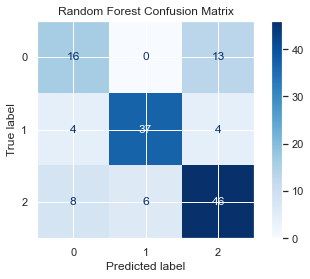

In [256]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

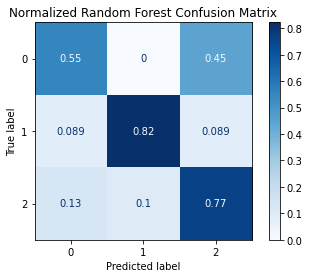

In [257]:
sns.reset_orig()
norm_matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

sns.set()

ep
Accuracy: 0.8134328358208955
ROC: 0.896551724137931 

pilo
Accuracy: 0.8955223880597015
ROC: 0.9523096129837703 

mb
Accuracy: 0.7686567164179104
ROC: 0.8529279279279279 

Micro-Averaged AUC: 0.9004511026954779


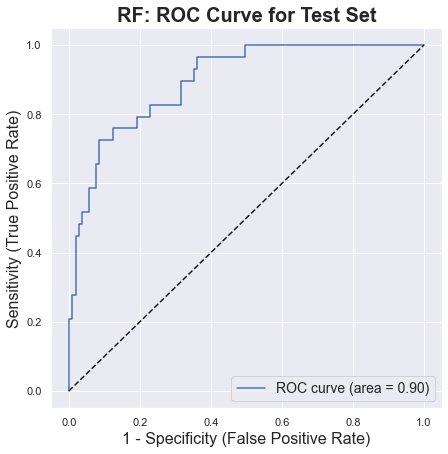

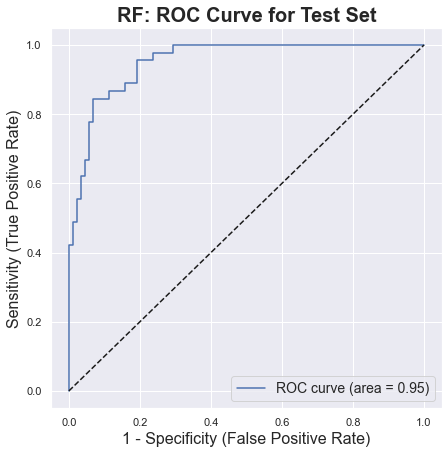

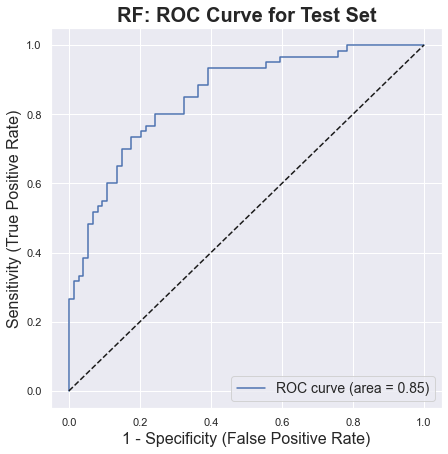

In [258]:
y_score = rf_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print("ROC: " + str(roc_auc[i]), '\n')    

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('RF: ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [259]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [260]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.8324 - 0.9484]
95% Confidence interval for the AUC score for class 1: [0.9157 - 0.9814]
95% Confidence interval for the AUC score for class 2: [0.7862 - 0.9142]
95% Confidence interval for the Accuracy score for class 0: [0.7463 - 0.8731]
95% Confidence interval for the Accuracy score for class 1: [0.8433 - 0.9478]
95% Confidence interval for the Accuracy score for class 2: [0.6940 - 0.8358]
95% Confidence interval for the Specificity score for class 0: [0.8214 - 0.9434]
95% Confidence interval for the Specificity score for class 1: [0.8736 - 0.9785]
95% Confidence interval for the Specificity score for class 2: [0.6706 - 0.8594]
95% Confidence interval for the Precision score for class 0: [0.3600 - 0.7273]
95% Confidence interval for the Precision score for class 1: [0.7000 - 0.9302]
95% Confidence interval for the Precision score for class 2: [0.6607 - 0.875]
95% Confidence interval for the Recall score for class 0: [0.3793 - 

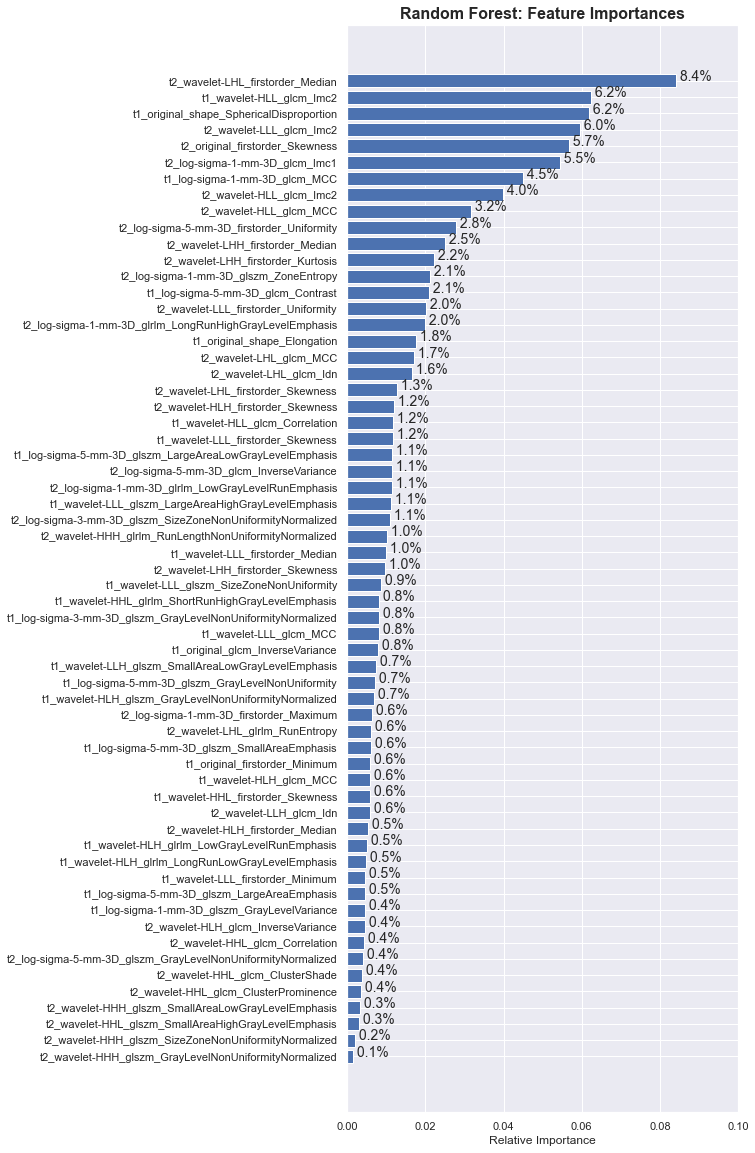

In [261]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7, 20)) ##
plt.title('Random Forest: Feature Importances', fontsize=16, fontweight='semibold') ##
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.10) ##
for index, value in enumerate(importances[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost

### Grid Search for Hyperparameters

In [262]:
xgb_model = XGBClassifier(objective = 'multi:softmax', random_state = 42)
grid_param = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

xgb_grid = GridSearchCV(estimator=xgb_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [263]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsampl

In [264]:
print(xgb_grid.best_params_)

{'learning_rate': 0.5, 'max_depth': 6}


### Model Performance

In [265]:
xgb_model = XGBClassifier(objective = 'multi:softmax', learning_rate = 0.5, max_depth = 6, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [266]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.9238095238095239
1 0.9550561797752809
2 0.7162162162162162
Macro Avg : 0.8650273066003403
Micro Avg : 0.8768656716417911 

PPV/Precision
0 0.6521739130434783
1 0.8947368421052632
2 0.7123287671232876
Macro Avg : 0.753079840757343
Micro Avg : 0.753731343283582 

NPV
0 0.8738738738738738
1 0.8854166666666666
2 0.8688524590163934
Macro Avg : 0.8760476665189779
Micro Avg : 0.8768656716417911 

Recall
0 0.5172413793103449
1 0.7555555555555555
2 0.8666666666666667
Macro Avg : 0.713154533844189
Micro Avg : 0.753731343283582 

F1 Score
0 0.576923076923077
1 0.8192771084337349
2 0.7819548872180451
Macro Avg : 0.7325736077204064
Micro Avg : 0.753731343283582 

Accuracy:
0 0.835820895522388
1 0.8880597014925373
2 0.7835820895522388
Macro Avg : 0.8358208955223881
Micro Avg : 0.835820895522388 



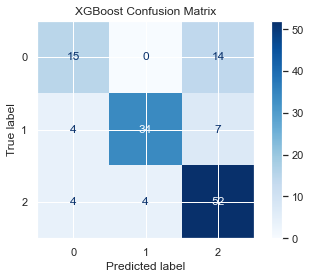

In [267]:
matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

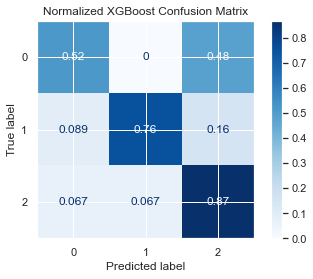

In [268]:
norm_matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

ep
Accuracy: 0.835820895522388
ROC: 0.8669950738916257 

pilo
Accuracy: 0.8880597014925373
ROC: 0.9640449438202248 

mb
Accuracy: 0.7835820895522388
ROC: 0.8817567567567568 

Micro-Averaged AUC: 0.9114780574738248


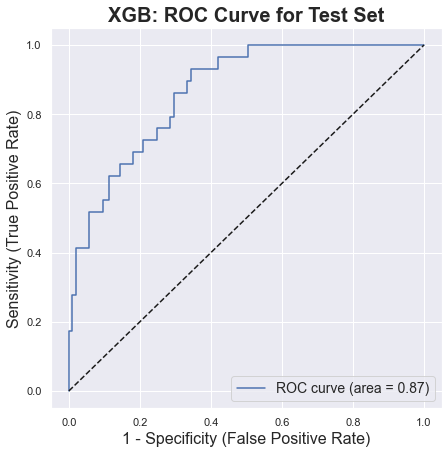

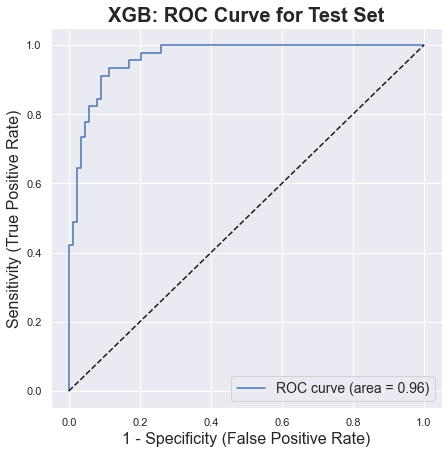

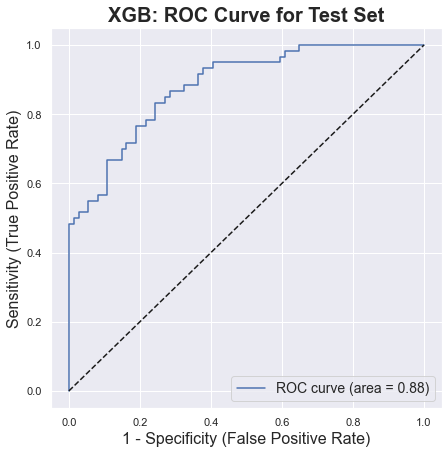

In [269]:
y_score = xgb_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print("ROC: " + str(roc_auc[i]), '\n')
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('XGB: ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [270]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [271]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.7979 - 0.9289]
95% Confidence interval for the AUC score for class 1: [0.9336 - 0.9868]
95% Confidence interval for the AUC score for class 2: [0.8221 - 0.9329]
95% Confidence interval for the Accuracy score for class 0: [0.7687 - 0.8955]
95% Confidence interval for the Accuracy score for class 1: [0.8358 - 0.9403]
95% Confidence interval for the Accuracy score for class 2: [0.7090 - 0.8507]
95% Confidence interval for the Specificity score for class 0: [0.8713 - 0.9714]
95% Confidence interval for the Specificity score for class 1: [0.9053 - 0.9894]
95% Confidence interval for the Specificity score for class 2: [0.6056 - 0.8143]
95% Confidence interval for the Precision score for class 0: [0.3333 - 0.7083]
95% Confidence interval for the Precision score for class 1: [0.6190 - 0.875]
95% Confidence interval for the Precision score for class 2: [0.7742 - 0.95]
95% Confidence interval for the Recall score for class 0: [0.4444 - 0.

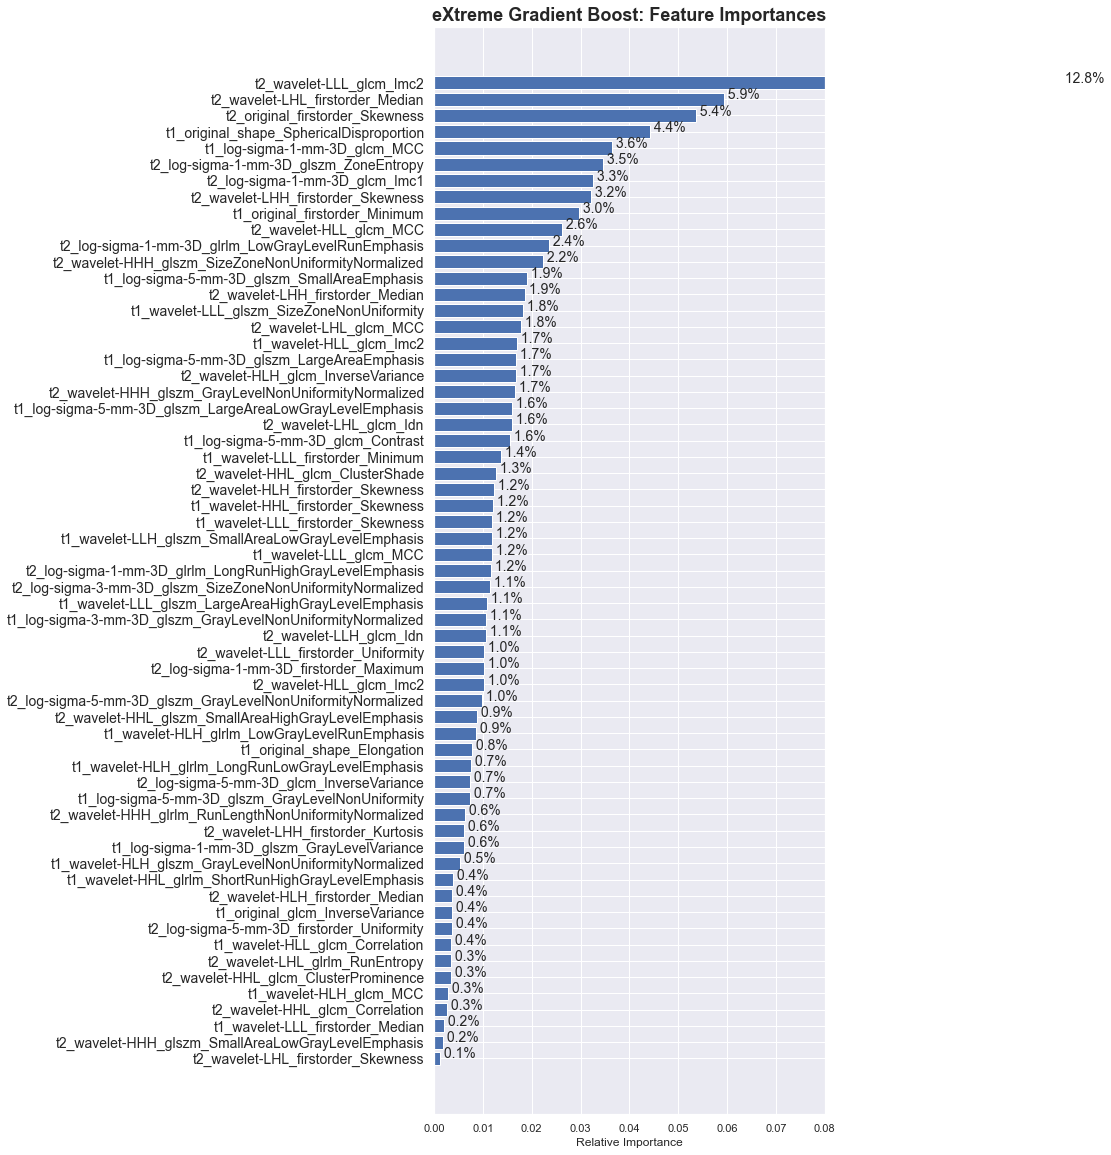

In [272]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7, 20)) ##
plt.title('eXtreme Gradient Boost: Feature Importances', fontsize=18, fontweight='semibold') ##
plt.xlim(0, 0.08) ##
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
for index, value in enumerate(importances[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14)
plt.xlabel('Relative Importance')

plt.show()

# Neural Net

### Grid Search for Hyperparameters

In [273]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_grid = GridSearchCV(estimator=nn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [274]:
nn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [275]:
print(nn_grid.best_params_)

{'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant'}


### Model Performance

In [276]:
nn_model = MLPClassifier(hidden_layer_sizes = (50, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [277]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.8571428571428571
1 0.9887640449438202
2 0.7972972972972973
Macro Avg : 0.8810680664613249
Micro Avg : 0.8843283582089553 

PPV/Precision
0 0.5
1 0.9743589743589743
2 0.7692307692307693
Macro Avg : 0.7478632478632479
Micro Avg : 0.7686567164179104 

NPV
0 0.8653846153846154
1 0.9263157894736842
2 0.855072463768116
Macro Avg : 0.8822576228754718
Micro Avg : 0.8843283582089553 

Recall
0 0.5172413793103449
1 0.8444444444444444
2 0.8333333333333334
Macro Avg : 0.7316730523627076
Micro Avg : 0.7686567164179104 

F1 Score
0 0.5084745762711865
1 0.9047619047619048
2 0.8
Macro Avg : 0.7396795674839792
Micro Avg : 0.7686567164179104 

Accuracy:
0 0.7835820895522388
1 0.9402985074626866
2 0.8134328358208955
Macro Avg : 0.8457711442786069
Micro Avg : 0.845771144278607 



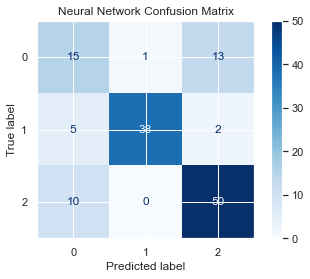

In [278]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

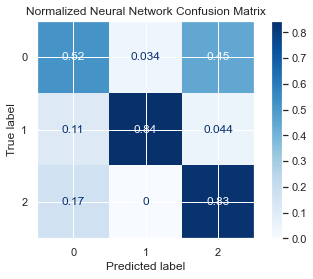

In [279]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

ep
Accuracy: 0.7835820895522388
ROC: 0.7885057471264367 

pilo
Accuracy: 0.9402985074626866
ROC: 0.9710362047440699 

mb
Accuracy: 0.8134328358208955
ROC: 0.8957207207207207 

Micro-Averaged AUC: 0.9042102918244598


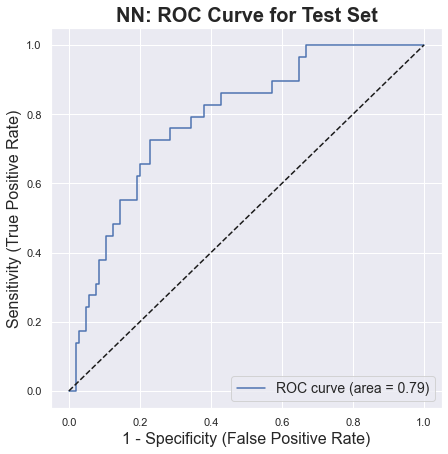

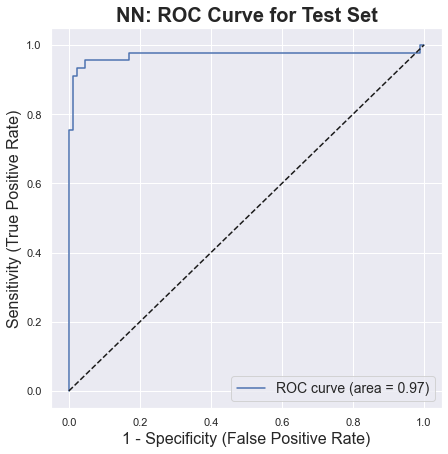

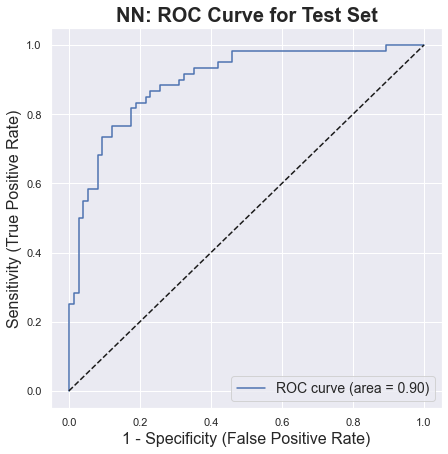

In [280]:

y_score = nn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print("ROC: " + str(roc_auc[i]), '\n')
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('NN: ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [281]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [282]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.6924 - 0.873]
95% Confidence interval for the AUC score for class 1: [0.9205 - 0.9991]
95% Confidence interval for the AUC score for class 2: [0.8369 - 0.9454]
95% Confidence interval for the Accuracy score for class 0: [0.7090 - 0.8507]
95% Confidence interval for the Accuracy score for class 1: [0.8955 - 0.9776]
95% Confidence interval for the Accuracy score for class 2: [0.7463 - 0.8806]
95% Confidence interval for the Specificity score for class 0: [0.7890 - 0.9217]
95% Confidence interval for the Specificity score for class 1: [0.9643 - 1.0]
95% Confidence interval for the Specificity score for class 2: [0.7027 - 0.8868]
95% Confidence interval for the Precision score for class 0: [0.3333 - 0.6957]
95% Confidence interval for the Precision score for class 1: [0.7292 - 0.9412]
95% Confidence interval for the Precision score for class 2: [0.7333 - 0.9219]
95% Confidence interval for the Recall score for class 0: [0.3125 - 0.6